In [2]:
import sys
import os
sys.path.append('../')

from dataset.data import split_data
from question1 import eigen
from question2 import inc_pca

from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
from sklearn.neighbors import KNeighborsClassifier

1. Further divide the training data equally into four subsets, each with 104 images

In [3]:
data_path = "../dataset/face.mat"
train_data, train_label, test_data, test_label = split_data(data_path)

# 1. additional seperation of the training data
train_data1 = train_data[:, 0::4]
train_data2 = train_data[:, 1::4]
train_data3 = train_data[:, 2::4]
train_data4 = train_data[:, 3::4]

train_label1 = train_label[0::4]
train_label2 = train_label[1::4]
train_label3 = train_label[2::4]
train_label4 = train_label[3::4]

train_data = np.hstack([train_data1, train_data2, train_data3, train_data4])
train_label = np.concatenate([train_label1, train_label2, train_label3, train_label4])

2. Perform Incremental PCA, and compare it with the counterpart i.e. batch PCA, and PCA 
trained only by the first subset

    training time, reconstruction error, face recognition accuracy (using NN classification).   
    * time 측정 시 eigen-decomposition 제외 무시해도 됨 -> eigen-decomposition 부분에만 time을 달면 됨

In [4]:
# Incremental PCA: calculate batch time and memory, average of 10-time execution
total_time = []
batch_time = []
combine_time = []
memory_usage = []
for i in range (10):
    ipca = inc_pca.IncrementalPCA(n_components=50, check_performance = True)
    eigvals, eigvecs = ipca.fit(train_data, 104)
    batch_time.append(ipca.new_batch_t)
    combine_time.append(ipca.combine_t)
    memory_usage.append(ipca.combine_m)

New batch eigen decomposition time: 0.06658 sec
[incremental_pca_eigen_decomposition] memory usage:  155.57031 MB
New batch eigen decomposition time: 0.01854 sec
[incremental_pca_eigen_decomposition] memory usage:  266.08984 MB
combined covariance matrix decomposition time: 0.01695 sec
[incremental_pca_eigen_decomposition] memory usage:  331.86328 MB
result shape:  (2576, 50) (50,)
New batch eigen decomposition time: 0.02270 sec
[incremental_pca_eigen_decomposition] memory usage:  278.05078 MB
combined covariance matrix decomposition time: 0.01279 sec
[incremental_pca_eigen_decomposition] memory usage:  331.21484 MB
result shape:  (2576, 50) (50,)
New batch eigen decomposition time: 0.01827 sec
[incremental_pca_eigen_decomposition] memory usage:  278.70703 MB
combined covariance matrix decomposition time: 0.01572 sec
[incremental_pca_eigen_decomposition] memory usage:  331.32422 MB
result shape:  (2576, 50) (50,)
New batch eigen decomposition time: 0.02384 sec
[incremental_pca_eigen_de

In [19]:
print("time")
print(ipca.new_batch_t)
print(ipca.combine_t)
print("mem")
print(ipca.new_batch_m)
print(ipca.combine_m)

#print(ipca.eigenval)

time
[0.02951359748840332, 0.02308940887451172, 0.02816033363342285, 0.03240513801574707]
[0.0, 0.029072046279907227, 0.021047353744506836, 0.023463726043701172]
mem
[199.20703125, 303.1640625, 302.4296875, 302.4296875]
[0.0, 356.09375, 355.046875, 355.046875]


In [22]:
# average calculation: 여기서 total time이 training time으로 쓰일 수 있음
batch_time = np.array(batch_time)
combine_time = np.array(combine_time)
memory_usage = np.array(memory_usage)

batch_time_avg = batch_time.mean(axis=0)
combine_time_avg = combine_time[:, 1:].mean(axis=0)
combine_time_avg = np.concatenate(([0.0], combine_time_avg), axis=0)
total_time = batch_time_avg + combine_time_avg

memory_usage_avg = memory_usage.mean(axis=0)

print(batch_time_avg)
print(combine_time_avg)
print(total_time)
print(memory_usage_avg)

[0.04676313 0.03983629 0.0418273  0.03831799]
[0.         0.02973506 0.0295357  0.03628094]
[0.04676313 0.06957135 0.071363   0.07459893]
[  0.         356.23828125 355.04453125 355.05078125]


-> how accurate your incremental method is, what important parameters in the method are???

In [25]:
mean_face = np.mean(train_data, axis=1).reshape(-1, 1)
val_batch, vec_batch = eigen.pca(train_data, mean_face)
print(val_batch[:5])

batch_size = 104

pca_time = []
pca_mem = []
for i in range (4):
    cur_train_data = train_data[:, :(i+1) * 104]
    cur_train_label = train_label[:(i+1) * 104]
    mean_face = np.mean(cur_train_data, axis=1).reshape(-1, 1)
    val_batch, vec_batch, t, m = eigen.pca_perf(cur_train_data, mean_face)
    pca_time.append(t)
    pca_mem.append(m)
print(pca_time)
print(pca_mem)

[916420.71213223 536260.72828332 450658.20970479 253402.13754361
 221169.88932295]
 0.03208 sec
[pca] memory usage:  210.00391 MB
 0.14990 sec
[pca] memory usage:  208.28906 MB
 0.45804 sec
[pca] memory usage:  214.08594 MB
 1.11707 sec
[pca] memory usage:  221.54688 MB
[0.03207969665527344, 0.1499018669128418, 0.4580376148223877, 1.1170709133148193]
[210.00390625, 208.2890625, 214.0859375, 221.546875]


In [64]:
# saving
# 결과 제대로 나왔을때만 키기
#io.savemat('inc-batch-timemem.mat', {'inc_time':total_time, 'inc_batch_time': batch_time_avg,
#                                     'inc_comb_time': combine_time_avg, 'inc_mem': memory_usage_avg,
#                                     'batch_time': pca_time, 'batch_mem': pca_mem})


(4,) (4,)


Text(0.5, 0.98, 'Incremental PCA vs Batch PCA: training time and memory')

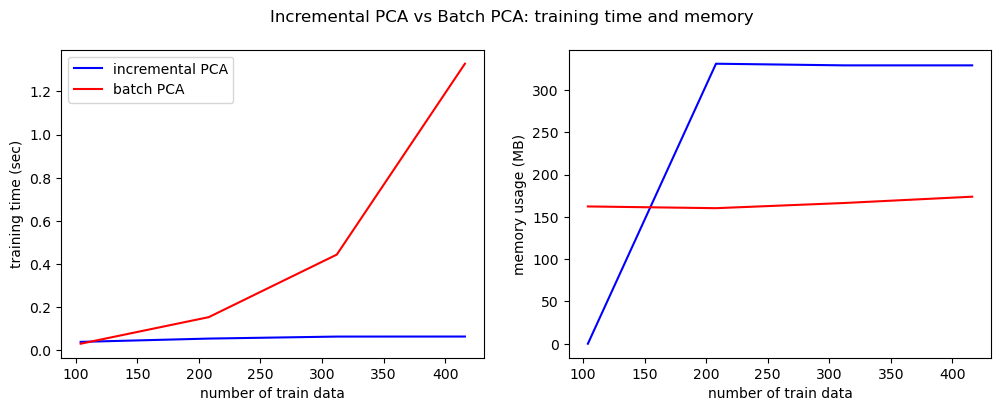

In [6]:
# 1. batch vs inc PCA, time and memory
base_dir = os.getcwd()  
full_data_path = os.path.join(base_dir, "./inc-batch-timemem.mat")
file = io.loadmat(full_data_path)
inc_time = np.array(file["inc_time"]).flatten()
inc_mem = np.array(file["inc_mem"]).flatten()
batch_time = np.array(file["batch_time"]).flatten()
batch_mem = np.array(file["batch_mem"]).flatten()

graph = plt.figure(figsize=(12, 4))
ax1 = graph.add_subplot(121)
ax2 = graph.add_subplot(122)
X = np.arange(104, 417, 104)
print(X.shape, inc_time.shape)

ax1.plot(X, inc_time, color='b', label='incremental PCA')
ax1.plot(X, batch_time, color='r', label='batch PCA')
ax1.set_xlabel('number of train data')
ax1.set_ylabel('training time (sec)')
ax1.legend()

ax2.plot(X, inc_mem, color='b', label='incremental PCA')
ax2.plot(X, batch_mem, color='r', label='batch PCA')
ax2.set_xlabel('number of train data')
ax2.set_ylabel('memory usage (MB)')

plt.suptitle('Incremental PCA vs Batch PCA: training time and memory')
# 결과 제대로 나왔을때만 키기
#plt.savefig('q2-fig1', dpi=300)

In [7]:
# ------------------------
# 여기 아래로 실험은 이거만 돌리면 다 가능함, 2, 3, 4 실험을 위한 기본 데이터 뽑는 과정

pca_mean = []
pca_eigenvec = []
pca_eigenval = []
for i in range (4):
    cur_train_data = train_data[:, :(i+1) * 104]
    cur_train_label = train_label[:(i+1) * 104]
    mean_face = np.mean(cur_train_data, axis=1).reshape(-1, 1)
    val_batch, vec_batch = eigen.pca(cur_train_data, mean_face)
    pca_mean.append(mean_face)
    pca_eigenvec.append(vec_batch)
    pca_eigenval.append(val_batch)

ipca = inc_pca.IncrementalPCA(n_components=50, step_save=True)
eigvals, eigvecs = ipca.fit(train_data, 104)

result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)


[1. 1. 1. 1.] [1.         0.90095859 0.89137504 0.8561277 ] [1.         0.99999556 0.99999034 0.99998515]


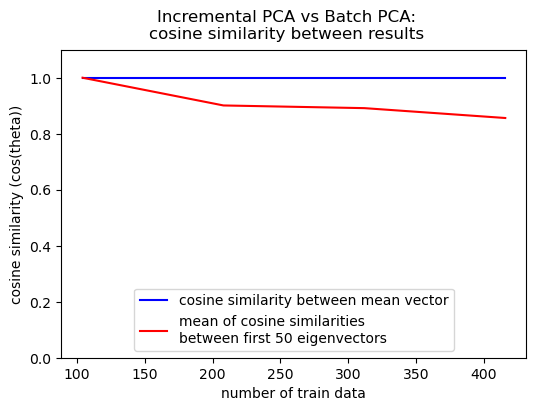

In [29]:
# 2. batch vs inc PCA, eigenvector/mean cosine similarity by first 50 components
#idx 0, 1, 2, 3에 각각 104, 208, 312, 416 train data에서 similarity가 들어감
from sklearn.metrics.pairwise import cosine_similarity

mean_similarity = []
vec_similarity = []
val_similarity = []
for i in range (4):
    cur_batch_mean = pca_mean[i]
    cur_batch_vec = pca_eigenvec[i][:,:50]
    cur_batch_val = pca_eigenval[i][:50].reshape(-1, 1)
    cur_inc_mean = ipca.step_mean[i]
    cur_inc_vec = ipca.step_eigenvec[i]
    cur_inc_val = ipca.step_eigenval[i].reshape(-1, 1)

    mean_similarity.append(cosine_similarity(cur_batch_mean.T, cur_inc_mean.T))
    vec_similarity.append(np.diag(cosine_similarity(cur_batch_vec.T, cur_inc_vec.T)))
    val_similarity.append(cosine_similarity(cur_batch_val.T, cur_inc_val.T))

mean_similarity = np.array(mean_similarity).flatten()
vec_similarity = abs(np.array(vec_similarity)).mean(axis=1)
val_similarity = np.array(val_similarity).flatten()

# 1, 2, 3, 4 batch에서 mean / eigenvector cosine similarity
print(mean_similarity, vec_similarity, val_similarity)

# draw graph
graph = plt.figure(figsize=(6, 4))
ax1 = graph.add_subplot(111)
X = np.arange(104, 417, 104)
ax1.set_ylim([0.0, 1.1])

ax1.plot(X, mean_similarity, color='b', label='cosine similarity between mean vector')
ax1.plot(X, vec_similarity, color='r', label='mean of cosine similarities\nbetween first 50 eigenvectors')
#ax1.plot(X, val_similarity, color='g', label='cosine similarities between first 50 eigenvalues')

ax1.set_xlabel('number of train data')
ax1.set_ylabel('cosine similarity (cos(theta))')
ax1.legend(loc='lower center')

plt.suptitle('Incremental PCA vs Batch PCA:\ncosine similarity between results')
plt.savefig('q2-fig2', dpi=300)

In [45]:
# 3. batch vs inc PCA, reconstruction error by first 50 components
M = 50

mean_face = np.mean(train_data, axis=1).reshape(-1, 1)
val_batch, vec_batch = eigen.pca(train_data, mean_face)

ipca = inc_pca.IncrementalPCA(n_components=M, step_save=True)
eigvals, eigvecs = ipca.fit(train_data, 104)

theoretical_error = []
batch_error = []
inc_error = np.zeros((4, M))
for i in range (1, M+1):
    th, bh = eigen.face_reconstruction(test_data, val_batch, vec_batch, mean_face, M = i)
    theoretical_error.append(th)
    batch_error.append(bh)

    for j in range (0, 4):
        _, inc = eigen.face_reconstruction(test_data, ipca.step_eigenval[j], ipca.step_eigenvec[j], ipca.step_mean[j], M = i)
        inc_error[j][i-1] = inc

result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)


(50,)
(50,)
(50,)
(50,)


Text(0.5, 1.0, 'Test data reconstruction error according to the number of PCA bases')

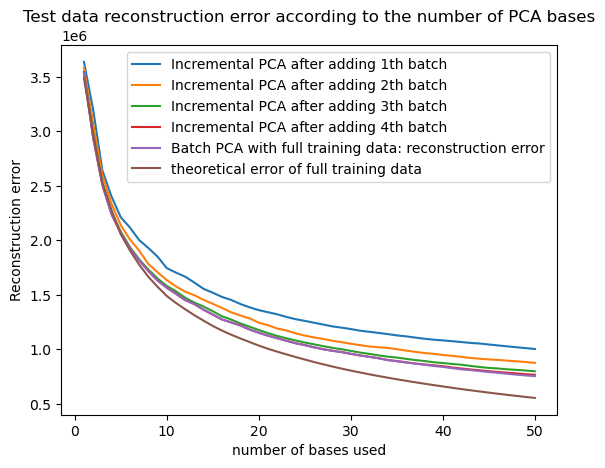

In [53]:
# problem3: draw graph
graph = plt.figure()
ax1 = graph.add_subplot(111)
X = np.arange(1, M+1)

for j in range (0,4):
    print(inc_error[j].shape)
    ax1.plot(X, inc_error[j], label="Incremental PCA after adding {}th batch".format(j+1))

ax1.plot(X, batch_error, label='Batch PCA with full training data: reconstruction error')
ax1.plot(X, theoretical_error, label='theoretical error of full training data')

ax1.set_ylabel('Reconstruction error')
ax1.set_xlabel('number of bases used')

plt.legend()
plt.title('Test data reconstruction error according to the number of PCA bases')

In [48]:
# 4. batch vs inc PCA, KNN classification accuracy by first 50 components
n_neighbors = 5

batch_knn = []
inc_knn = np.zeros((4, M))
for i in range (1, M+1):
    train_PCA_data = eigen.pca_transform(train_data, val_batch, vec_batch, mean_face, M = i)
    test_PCA_data = eigen.pca_transform(test_data, val_batch, vec_batch, mean_face, M = i)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
    model.fit(train_PCA_data.T, train_label)
    batch_knn.append(model.score(test_PCA_data.T, test_label))

    for j in range (0, 4):
        train_PCA_data = eigen.pca_transform(train_data, ipca.step_eigenval[j], ipca.step_eigenvec[j], ipca.step_mean[j], M = i)
        test_PCA_data = eigen.pca_transform(test_data, ipca.step_eigenval[j], ipca.step_eigenvec[j], ipca.step_mean[j], M = i)

        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
        model.fit(train_PCA_data.T, train_label)
        inc_knn[j][i-1] = model.score(test_PCA_data.T, test_label)

Text(0.5, 1.0, 'KNN classification accuracy according to the number of PCA bases')

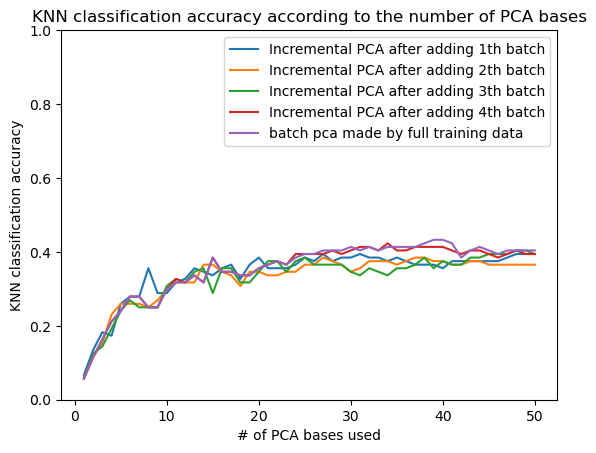

In [54]:
# problem4: draw graph
graph = plt.figure()
ax1 = graph.add_subplot(111)
ax1.set_ylim([0.0, 1.0])
X = np.arange(1, M+1)

for j in range (0,4):
    ax1.plot(X, inc_knn[j], label="Incremental PCA after adding {}th batch".format(j+1))
ax1.set_ylabel('KNN classification accuracy')
ax1.set_xlabel('# of PCA bases used')

ax1.plot(X, batch_knn, label='batch pca made by full training data')

plt.legend()
plt.title('KNN classification accuracy according to the number of PCA bases')

In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload